# Example notebook: Studying and mitigating the effects of data drifts on ML model performance

This notebook is part of the supporting information to the manuscript entitled: *Studying and mitigating the effects of data drifts on ML model performance at the example of chemical toxicity data*
* Authors: A. Morger, M. Garcia de Lomana, U. Norinder, F. Svensson, J. Kirchmair, M. Mathea, and A. Volkamer
* Last updated: August 2021

In this notebook, the use of the Conformal prediction (CP) classes to study and mitigate the effects of data drifts on model calibration are demonstrated. The ChEMBL dataset, as used in the manuscript, for endpoint "CHEMBL228" is loaded as example. You can also exchange it with your own data.

## Import packages and modules

In [1]:
import pandas as pd
import numpy as np
import sys
import tarfile

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

In [3]:
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory

In [4]:
from continuous_calibration import (
StratifiedRatioSampler, BalancedStratifiedRatioSampler, CrossValidationSampler, InductiveConformalPredictor, 
    ContinuousCalibrationAggregatedConformalPredictor, CrossValidator
)
from continuous_calibration_helper_functions import draw_scatter_plot_one_endpoint, create_umap_data, plot_umap

## Define paths and parameters

In [5]:
# Dataset with all 12 ChEMBL endpoints. Note that due to its size 
# it is not provided in this GitHub repository. Download it from
# Zenodo instead and copy it to the `data` folder.
data_path = "../data/chembl_chembio_descriptors.tar.bz2"
# Dataset for ChEMBL228 endpoint
data_path = "../data/CHEMBL228_chembio_normalizedDesc.csv.tar.bz2"
# Dataset defining the splits by publication year into the CP subsets.
# Contains information for all 12 endpoints.
time_split_threshold_path = "../data/data_size_chembio_chembl.csv"

Choose an endpoint. 

In [6]:
# Note that due to the size of the datasets, 
# only one dataset for ChEMBL228 endpoint is available from GitHub.
# Data for other ChEMBL endpoints can be downloaded from Zenodo (link_to_zenodo).
endpoint = "CHEMBL228"

Define parameters for machine learning and conformal prediction.

Note that the calculations take time and computational resources. If you just want to try out the notebook, we recommend using the small values provided. To get the same plots as in the manuscript (maybe small deviations due to random splitting and random forest), replace them by the larger, commented values.

In [7]:
ntrees = 50  # 500
n_folds_acp = 3  # 20
# Defines how to split training data into calibration and proper
# training set using stratified spliting. Default is test_ratio=0.3,
# i.e. allocate 30% of data to calibration set
ratio_sampler = StratifiedRatioSampler(n_folds=n_folds_acp)

Define UMAP parameters for compound descriptor space analysis.

In [8]:
descriptors = "chembio"
n_neighbors = 100
min_distances = 0.8
distance_metric = "euclidean"
umap_colours = ["navy", "magenta", "orangered", "green"]

## Load and preprocess the data

### Load data for ChEMBL228 endpoint

Due to the size of the datasets, which contain the precalculated chembio descriptors, the example data for ChEMBL228 endpoint was deposited on GitHub as compressed file. 

The data contains:
* Molecule ChEMBL ID
* SMILES
* Publication date
* Binary activity (0 or 1)
* Precalculated ChemBio descriptors

In [9]:
data = pd.read_csv(data_path, compression='bz2', index_col=0)
data.head()

,CHEMBL228_bioactivity,molecule_chembl_id,year,Strongest ACIDIC pKa 1,Strongest ACIDIC pKa 2,Strongest BASIC pKa 1,Strongest BASIC pKa 2,SlogP,SMR,LabuteASA,...,p0-ToxCast_TOX21_p53_BLA_p5_ratio_InVitro,p1-ToxCast_TOX21_p53_BLA_p5_ratio_InVitro,p0-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Agonist_InVitro,p1-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Agonist_InVitro,p0-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Antagonist_InVitro,p1-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Antagonist_InVitro,p0-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Cytoplasm_Ratio_Antagonist_InVitro,p1-ToxCast_UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Cytoplasm_Ratio_Antagonist_InVitro,p0-ToxCast_NCCT_HEK293T_CellTiterGLO_InVitro,p1-ToxCast_NCCT_HEK293T_CellTiterGLO_InVitro
CHEMBL228_chembio_normalizedDesc.csv,,,,,,,,,,,,,,,,,,,,,
Brc1cc(O[C@H]2C[C@@H]3CC[C@H](C2)N3)cc(-c2ccccc2)c1,0.0,CHEMBL1644601,2011.0,-2.809112e-15,5.939682e-15,1.302647,-3.673721e-16,0.559000,-0.269953,-0.311607,...,-0.271379,-0.124748,-0.817191,0.782127,-0.588356,0.537403,-0.234571,0.169539,-0.779707,0.794822
Brc1ccc(N2CCN(CCCCOc3ccc4ccccc4c3)CC2)cc1,0.0,CHEMBL4294090,2018.0,-2.809112e-15,5.939682e-15,-0.469983,-1.712712e+00,1.195275,0.840088,0.625818,...,-0.748681,0.594661,0.508205,-0.604907,-0.131702,-0.073389,-0.288971,0.227672,-0.884506,1.350940
Brc1ccc(N2CCN(CCCN3CCC(Cc4ccccc4)CC3)CC2)cc1,0.0,CHEMBL3775012,2016.0,-2.809112e-15,5.939682e-15,0.383832,2.511407e+00,0.667995,1.046026,0.854395,...,-0.505029,0.078336,-0.605172,0.579285,-0.321704,0.146703,-1.160155,1.278064,-0.884357,1.210984
Brc1ccc(N2CCN(CCCOc3ccc4ccccc4c3)CC2)cc1,1.0,CHEMBL4283496,2018.0,-2.809112e-15,5.939682e-15,-0.790863,-1.698674e+00,0.887168,0.658979,0.460180,...,-0.540919,0.204206,0.713899,-0.785441,-0.086008,-0.127980,-0.187862,0.127924,-0.907245,1.275077
Brc1ccc(N2CCN(CCN3CCC(Cc4ccccc4)CC3)CC2)cc1,0.0,CHEMBL3775085,2016.0,-2.809112e-15,5.939682e-15,0.102462,1.316044e+00,0.359888,0.864918,0.688757,...,-0.228433,-0.201849,-0.564613,0.373680,-0.233987,-0.000591,-1.045112,1.088714,-0.886296,1.230637


### Load data for another endpoint

If you want to run the example notebook for any other ChEMBL endpoint, a compressed file with all ChEMBL datasets used in this work can be downloaded from [Zenodo](link_to_zenodo) as tar.bz2 files. Change the `endpoint` in Cell 6 and uncomment the following three cells.

### Define arrays with labels, descriptors and publication years

Drop rows without any information on the publication date. 

In [10]:
# The publication date is required for temporal data splitting.
data.dropna(subset=["year"], inplace=True)

Define the labels for the ML experiment, i.e., the measured binarized bioactivities.

In [11]:
y = data[f"{endpoint}_bioactivity"].values
y

array([0., 0., 0., ..., 1., 1., 1.])

Define feature columns from the ChemBio descriptor, i.e., p-values and chemical descriptors.

In [12]:
# Any other columns present in the dataset, but not part of the descriptors, are explicitly excluded.

columns = [
            col
            for col in data.columns
            if (not col.startswith("Toxicity"))  # Exclude in vivo labels used for p-values
            and (col != f"{endpoint}_bioactivity")  # Exclude ChEMBL bioactivity labels
            and (col != "SMILES (Canonical)")  # Exclude canonical smiles
            and (col != "smiles")  # Exclude smiles
            and (col != "year")  # Exclude publication year
            and (col != "molecule_chembl_id")  # Exclude molecule ChEMBL id
        ]

X = data[columns].values
X

array([[-2.80911163e-15,  5.93968226e-15,  1.30264678e+00, ...,
         1.69538682e-01, -7.79707476e-01,  7.94822309e-01],
       [-2.80911163e-15,  5.93968226e-15, -4.69982792e-01, ...,
         2.27671782e-01, -8.84505678e-01,  1.35093976e+00],
       [-2.80911163e-15,  5.93968226e-15,  3.83831965e-01, ...,
         1.27806444e+00, -8.84357296e-01,  1.21098428e+00],
       ...,
       [-2.80911163e-15,  5.93968226e-15,  1.11010701e+00, ...,
        -7.72733450e-01,  1.32371173e+00, -1.39837780e+00],
       [-2.80911163e-15,  5.93968226e-15,  7.09563407e-01, ...,
        -2.01146873e+00,  2.53051914e-01, -5.89647388e-01],
       [-2.80911163e-15,  5.93968226e-15, -1.14389134e-01, ...,
        -1.45764980e+00,  1.71728142e+00, -1.53578739e+00]])

Collect the publication years in an arry. This information will be used for temporal data splitting.

In [13]:
years = data["year"].values
years

array([2011., 2018., 2016., ..., 2018., 2009., 2014.])

### Split data

Here, we implement a time-split to separate the data in four subsets based on the publication year:
* training set
* update 1 set
* update 2 set
* holdout set

#### Load dataframe defining time-split thresholds per endpoint
The `time_split_threshold_path` variable holds the precalculated information which year is used per data set to create the time split data while retaining specific ratios (see manuscript for more details).

In [14]:
splits_df = pd.read_csv(time_split_threshold_path, index_col=0, 
                        usecols=["chembl_id", "train_thresh", "update1_thresh", "update2_thresh"])
splits_df

,train_thresh,update1_thresh,update2_thresh
chembl_id,,,
CHEMBL220,2014,2016,2017
CHEMBL4078,2014,2015,2016
CHEMBL5763,2015,2016,2017
CHEMBL203,2012,2014,2016
CHEMBL206,2006,2012,2016
CHEMBL279,2010,2013,2014
CHEMBL230,2010,2013,2015
CHEMBL340,2012,2014,2015
CHEMBL240,2012,2014,2016


In [15]:
splits_df.index

Index(['CHEMBL220', 'CHEMBL4078', 'CHEMBL5763', 'CHEMBL203', 'CHEMBL206',
       'CHEMBL279', 'CHEMBL230', 'CHEMBL340', 'CHEMBL240', 'CHEMBL2039',
       'CHEMBL222', 'CHEMBL228'],
      dtype='object', name='chembl_id')

Get year thresholds to split the data for the selected endpoint.

In [16]:
thresholds = splits_df["train_thresh"][endpoint], splits_df["update1_thresh"][endpoint], splits_df["update2_thresh"][endpoint]
thresholds

(2009, 2011, 2014)

Do the splitting based on the threshold.

In [17]:
# Collect the respective indices based on the threshold
mask_train = years <= thresholds[0]
mask_update1 = (years > thresholds[0]) & (years <= thresholds[1])
mask_update2 = (years > thresholds[1]) & (years <= thresholds[2])
mask_holdout = years > thresholds[2]

# Split the data accordingly
X_train, y_train = X[mask_train], y[mask_train]
X_update1, y_update1 = X[mask_update1], y[mask_update1]
X_update2, y_update2 = X[mask_update2], y[mask_update2]
X_holdout, y_holdout = X[mask_holdout], y[mask_holdout]

Inspect the data subsets.

In [18]:
# Check shape of the arrays
print(f"Training set shape: y={y_train.shape}, X={X_train.shape}")
print(f"Update1 set shape: y={y_update1.shape}, X={X_update1.shape}")
print(f"Update2 set shape: y={y_update2.shape}, X={X_update2.shape}")
print(f"Holdout set shape: y={y_holdout.shape}, X={X_holdout.shape}")

Training set shape: y=(1100,), X=(1100, 2344)
Update1 set shape: y=(470,), X=(470, 2344)
Update2 set shape: y=(266,), X=(266, 2344)
Holdout set shape: y=(275,), X=(275, 2344)


In [19]:
# Check if we have actives and inactives in all datasets
print(f"Active compounds training set: {y_train.sum()}")
print(f" update1 set: {y_update1.sum()}\n update2 set: {y_update2.sum()}\n holdout set: {y_holdout.sum()}")

Active compounds training set: 858.0
 update1 set: 373.0
 update2 set: 235.0
 holdout set: 196.0


## Conformal prediction recalibration strategy without crossvalidation (CV)

The experiments in this work were performed in a fivefold CV. For illustration of the recalibration strategy, it is, first, explained, step by step, without CV, in th next few cells. Note that the analysis of the models and predictions will be presented after the `crossvalidation` part.

### Prepare Aggregated Conformal Predictor (ACP)

In [20]:
clf = RandomForestClassifier(n_estimators=ntrees)
error_function = InverseProbabilityErrFunc()
nc = NcFactory.create_nc(
        clf, err_func=error_function, normalizer_model=None
    )
icp = InductiveConformalPredictor(
        nc_function=nc, smoothing=False, condition=(lambda instance: instance[1])
    )  # Mondrian as (default) condition)

In [21]:
acp = ContinuousCalibrationAggregatedConformalPredictor(predictor=icp, sampler=ratio_sampler,
        aggregation_func=np.median
    )

### Fit and calibrate the model, make predictions for holdout set

Calibrate with the `original` calibration set, which is a split from X_train/y_train.

In [22]:
acp.fit_calibrate(X_train=X_train, y_train=y_train)

Make predictions with the model and original calibration set on the holdout set.

In [23]:
original_prediction = acp.predict(X_test=X_holdout)

original_prediction[:5]

array([[0.37837838, 0.03875969],
       [0.34459459, 0.04263566],
       [0.31081081, 0.04457364],
       [0.30405405, 0.04844961],
       [0.17567568, 0.10465116]])

### Update calibration set I

Calibrate the fitted (not yet calibrated) predictors with a 'new' dataset

In [24]:
acp.calibrate_update(X_update=X_update1, y_update=y_update1)

1

Make predictions with the model and the updated calibration set 1 on the holdout set.

In [25]:
calibrate_update_prediction = acp.predict_calibrate_update(updated_number=1, X_test=X_holdout)
calibrate_update_prediction[:5]

array([[0.89285714, 0.01871658],
       [0.87244898, 0.02005348],
       [0.84183673, 0.02673797],
       [0.83163265, 0.02673797],
       [0.39285714, 0.15909091]])

### Update calibration set II

We can update with an even 'newer' calibration set (as often as we want). The model with the updated calibration set will be saved in the acp object.

In [26]:
# Check how many updated calibration sets we already have. 
# Here, this should be 1.
print(acp.predictors_calibrated_update.keys())

dict_keys(['update_1'])


In [27]:
acp.calibrate_update(X_update=X_update2, y_update=y_update2)

2

Make predictions with the model and the updated calibration set 2 on the holdout set.

In [28]:
calibrate_update_2_predcition = acp.predict_calibrate_update(updated_number=2, X_test=X_holdout)
calibrate_update_2_predcition[:5]

array([[0.9375    , 0.00847458],
       [0.9375    , 0.01271186],
       [0.9375    , 0.01271186],
       [0.90625   , 0.0190678 ],
       [0.5625    , 0.08686441]])

## Conformal prediction recalibration strategy within crossvalidation (CV)

Instead of using the individual acp's, we might want to include everything into a crossvalidator. 

Advantages: 
* Splitting of CV into test and train set are handled
* Fixed and reproducible pipeline (except for random splitting and random forest)
* Updating of the same trained models possible

Note that we use fivefold CV by default.

### Prepare ACP and crossvalidator class

In [29]:
cv_acp = ContinuousCalibrationAggregatedConformalPredictor(predictor=icp, sampler=ratio_sampler,
        aggregation_func=np.median
    )
cross_validator = CrossValidator(predictor=cv_acp, cv_splitter=CrossValidationSampler())

### Fit and calibrate the model, make predictions for holdout set

Predictions on the holdout set:

Crossvalidate with the "original" training set (no update calibration set)

In [30]:
cv_eval_df = cross_validator.cross_validate(X_train=X_train, y_train=y_train, X_test=X_holdout, y_test=y_holdout, steps=10, endpoint=endpoint)

### Analyse internal crossvalidation (with original calibration set)

* Evaluation per CV fold.
* Note that the metrics are calculated for significant levels between in the range of [0,1] (stepsize 0.1). Thus, you receive 11 entries per fold.

In [31]:
cv_eval_df[["validity", "efficiency", "accuracy", "significance_level", "fold"]].set_index("fold").head()

,validity,efficiency,accuracy,significance_level
fold,,,,
0,1.000,0.000,0.000,0.0
0,0.905,0.895,0.893,0.1
0,0.814,0.909,0.895,0.2
0,0.695,0.745,0.933,0.3
0,0.614,0.632,0.971,0.4


Averaged (all folds) evaluations, again per significant level

In [32]:
cross_validator.averaged_evaluation_df_cv[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.9110,0.8954,0.9008,0.1
0.2,0.8198,0.9082,0.9028,0.2
0.3,0.7182,0.7680,0.9348,0.3
0.4,0.6246,0.6536,0.9548,0.4
0.5,0.5402,0.5636,0.9574,0.5
0.6,0.4190,0.4338,0.9658,0.6
0.7,0.3084,0.3164,0.9740,0.7
0.8,0.2074,0.2126,0.9742,0.8


Balanced metrics, averaged (all folds) evaluations, again per significant level

In [33]:
cross_validator.averaged_evaluation_df_cv[["validity_bal mean", "efficiency_bal mean", "accuracy_bal mean", "significance_level"]]

,validity_bal mean,efficiency_bal mean,accuracy_bal mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.9132,0.9003,0.9036,0.1
0.2,0.8176,0.9038,0.9035,0.2
0.3,0.7104,0.7574,0.9372,0.3
0.4,0.6254,0.6498,0.9614,0.4
0.5,0.5532,0.5744,0.9620,0.5
0.6,0.4326,0.4450,0.9697,0.6
0.7,0.3187,0.3270,0.9724,0.7
0.8,0.2125,0.2160,0.9828,0.8


### Analyse CV performance when predicting the holdout set

Note the holdout set was already annotated when calling `cross_validator.cross_validate`. 

The `cross_validator` object stores the predictions in a dictionary that contains the information for the predictions within the crossvalidation and the predictions for the test (holdout) set. The predictions (values) are in the form of a list, list elements are the predicted p-values and the known labels:

In [34]:
print("keys: ", cross_validator._predictions.keys(), "\n")
print("p-values: ", cross_validator._predictions["pred_test"][0][0][:5], "\n")
# [0]: predictions, [0]: first loop of cv, [:5]: first five p-values
print("labels: ", cross_validator._predictions["pred_test"][1])
# [1]: labels

keys:  dict_keys(['cv', 'pred_test']) 

p-values:  [[0.44067797 0.04589372]
 [0.40677966 0.0531401 ]
 [0.39830508 0.0531401 ]
 [0.37288136 0.0531401 ]
 [0.22033898 0.09661836]] 

labels:  [[0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]]


Evaluation on the holdout set (averaged over all folds)

In [35]:
cross_validator.averaged_evaluation_df_pred_test[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.7846,0.6174,0.6506,0.1
0.2,0.4436,0.6736,0.6616,0.2
0.3,0.2168,0.2768,0.7832,0.3
0.4,0.1048,0.1308,0.7990,0.4
0.5,0.0452,0.0546,0.8316,0.5
0.6,0.0276,0.0300,0.9334,0.6
0.7,0.0080,0.0088,0.9500,0.7
0.8,0.0044,0.0044,0.6000,0.8


### Update the calibration set within the crossvalidator I

In [36]:
cross_validator.cross_validate_calibrate_update(X_update=X_update1, y_update=y_update1, X_test=X_holdout, y_test=y_holdout, steps=10, endpoint=endpoint)

Evaluating the predictions on the holdout set using the update I calibration set (averaged over all folds)

In [37]:
cross_validator.averaged_evaluation_df_cal_update_1[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.8642,0.5042,0.7340,0.1
0.2,0.7468,0.8036,0.6860,0.2
0.3,0.6518,0.9682,0.6686,0.3
0.4,0.5500,0.8108,0.6780,0.4
0.5,0.4624,0.6670,0.6930,0.5
0.6,0.3704,0.5200,0.7128,0.6
0.7,0.3026,0.4006,0.7576,0.7
0.8,0.2080,0.2612,0.7964,0.8


### Update the calibration set within the crossvalidator II

In [38]:

cross_validator.cross_validate_calibrate_update(X_update=X_update2, y_update=y_update2, X_test=X_holdout, y_test=y_holdout, steps=10, endpoint=endpoint)

Evaluating the predictions on the holdout set using the update II calibration set (averaged over all folds)

In [39]:
cross_validator.averaged_evaluation_df_cal_update_2[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.7330,0.6564,0.5934,0.1
0.2,0.5906,0.8982,0.5444,0.2
0.3,0.5002,0.8604,0.5820,0.3
0.4,0.4488,0.7440,0.6036,0.4
0.5,0.4028,0.6518,0.6190,0.5
0.6,0.3562,0.5578,0.6396,0.6
0.7,0.3076,0.4770,0.6468,0.7
0.8,0.2308,0.3440,0.6754,0.8


## Visualisations

### Scatter plot to compare different strategies

To compare balanced validity, balanced efficiency and balanced accuracy for the three strategies, they are plotted in a scatter plot.

In the following cells, the strategies and evaluation measures to be plotted are defined.

In [40]:
strategies = ["cv_original", "original", "update1"]
eval_df_columns = ["validity_bal mean", "efficiency_bal mean", "accuracy_bal mean", "significance_level"]

In [41]:
evaluation_measures = [m.split(" ")[0] for m in eval_df_columns[:-1]]
print(evaluation_measures)

['validity_bal', 'efficiency_bal', 'accuracy_bal']


In [46]:
evaluation_dfs_dict = {}
evaluation_dfs_dict["cv_original"] = cross_validator.averaged_evaluation_df_cv[eval_df_columns]
evaluation_dfs_dict["original"] = cross_validator.averaged_evaluation_df_pred_test[eval_df_columns]
evaluation_dfs_dict["update1"] = cross_validator.averaged_evaluation_df_cal_update_1[eval_df_columns]
evaluation_dfs_dict["update2"] = cross_validator.averaged_evaluation_df_cal_update_2[eval_df_columns]

Draw a scatter plot that compares balanced validity, efficiency and accuracy within the CV, and predicting the test set using the original and updated calibration set. The dashed line represents the expected validity (80%) at a significance level of 0.2.

(<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/recalibration_si/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <matplotlib.legend.Legend at 0x7ffad54c1a60>)

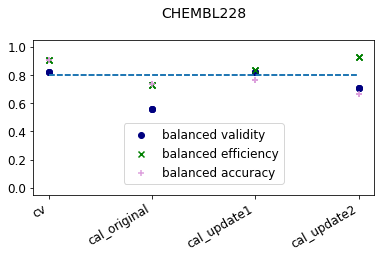

In [47]:
draw_scatter_plot_one_endpoint(endpoint, evaluation_dfs_dict, evaluation_measures=evaluation_measures)

### UMAP to analyse descriptor space of subsets

A UMAP can be helpful to analyse the chemical space of the subsets. Ideally, the update and holdout sets cover a similar descriptor space.
In the first step, we create an embedding, in a second step, this will be plotted.

In [44]:
embedding, colours_numbers = create_umap_data(
    chembl_id=endpoint, descriptors_df=data, thresholds=thresholds, n_neighbors=n_neighbors,
    min_distances=min_distances, distance_metric=distance_metric, dataset_colours=umap_colours)

desc chembio


2111


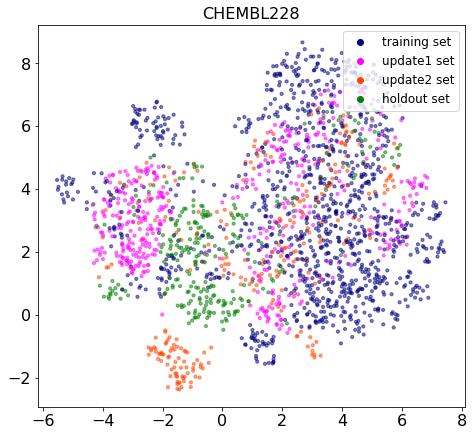

In [45]:
umap_plot = plot_umap(embedding, endpoint, colours_datasets=colours_numbers, umap_colours=umap_colours, n_neighbor=n_neighbors, min_distance=min_distances, distance_metric=distance_metric)